In [25]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
import re
import lightgbm as lgb
import datetime as dt
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

In [26]:
file = "Entrenamieto_ECI_2020.csv"
data = pd.read_csv(file)
data = data.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
data = data[(data.Stage == "Closed Won") | (data.Stage == "Closed Lost")]
data.Stage = data.Stage.replace({"Closed Won": 1, "Closed Lost": 0})

In [27]:
borrar = ["Opportunity_Name", "ID","Last_Activity", "Brand", "Product_Type", "ASP_converted_Currency", 
          "Prod_Category_A", "Product_Category_B", "Actual_Delivery_Date", "Last_Activity", 
          "ASP_converted_Currency", "Prod_Category_A", "Product_Name", "Delivery_Year", "Month", 
          "TRF", "Product_Family", "Account_Name"]
useless = ["Submitted_for_Approval", "Account_Type", "Delivery_Terms", "Size", "Price", "ASP_Currency", 
           "Total_Amount_Currency", "Total_Taxable_Amount_Currency","Quote_Type", "Opportunity_Type"]
dates = ["Account_Created_Date", "Opportunity_Created_Date", "Quote_Expiry_Date", "Last_Modified_Date", 
         "Planned_Delivery_Start_Date", "Planned_Delivery_End_Date"]
target = ["Opportunity_ID", "Stage", "Sales_Contract_No"]

In [32]:
def preprocess(data):
    
    # elimino caracteres prohibidos
    
    data = data.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
    
    for d in dates:
        data[d] = pd.to_datetime(data[d])

    # agrego features
    # Contacts: la cantidad de negociaciones registradas
    # Delivery_difference: la cantidad de dias entre las fechas planeadas final e inicial de delivery
    
    data["Contacts"] = data.groupby("Opportunity_ID", sort = False)["Opportunity_ID"].transform("count")
    data["Delivery_Difference"] = (data["Planned_Delivery_End_Date"] - data["Planned_Delivery_Start_Date"]).dt.days
    data["Concrete_Offer"] = (data["Planned_Delivery_End_Date"] - data["Opportunity_Created_Date"]).dt.days
    data.loc[data.Concrete_Offer <= 0, "Concrete_Offer"] = 0
    data["Offer_Duration"] = (data["Quote_Expiry_Date"] - data["Opportunity_Created_Date"]).dt.days
    data.loc[data.Offer_Duration <= 0, "Offer_Duration"] = -1
    #data["Same_Owner"] = data.Opportunity_Owner == data.Last_Modified_By
    data["Same_Owner"] = (data.Opportunity_Owner == data.Account_Owner) & (data.Opportunity_Owner == data.Last_Modified_By)
    data["Has_Brand"] = data.Brand != "None"
    data["Has_Contract"] = data.Sales_Contract_No != "None"
    data["Different_Country"] = (data.Billing_Country != data.Territory) & (data.Territory != "None")    
    data.loc[data.TRF == 0, "TRF_Cat"] = 0
    data.loc[(1 <= data.TRF) & (data.TRF <= 7), "TRF_Cat"] = 1
    data.loc[data.TRF > 7, "TRF_Cat"] = 2
    data["Sales"] = data.groupby("Account_Name", sort = False)["Account_Name"].transform("count")
    data["Past_Quote"] = (pd.to_datetime(data.Last_Modified_Date) - pd.to_datetime(data.Quote_Expiry_Date)).dt.days
    data["Has_Quote"] = ~(data.Offer_Duration.isna())

    # limpio columnas
    
    # casteo a categoricas varias columnas
    categorical = [x for x in data.columns if data[x].dtype == "object"]
    for c in categorical:       
        data[c] = data[c].astype("category")
    
    data = data.drop(borrar + useless + dates, axis = 1)

    return (data)

In [33]:
df = preprocess(data)

In [34]:
x_train, x_test, y_train, y_test = train_test_split(df, df.Stage, test_size = 0.3, random_state = 0)
categorical = ['Region', 'Territory', 'Bureaucratic_Code', 'Source', 'Billing_Country', 'Account_Name', 
               'Opportunity_Name', 'Account_Owner', 'Opportunity_Owner', 'Account_Type', 'Last_Modified_By',
               'Opportunity_Type', 'Quote_Type', 'Delivery_Terms', 'Brand', 'Product_Type', 'Size',
               'Product_Category_B', 'Price', 'Currency', 'Last_Activity', 'Product_Family', 
               'Product_Name', 'ASP_Currency', 'ASP_converted_Currency', 'Month', 'Delivery_Quarter', 
               'Actual_Delivery_Date', 'Total_Amount_Currency', 'Total_Taxable_Amount_Currency', 'Prod_Category_A',
               'TRF_Cat']
categorical = [x for x in categorical if x in df.columns]

In [35]:
train_data = lgb.Dataset(x_train.drop(target, axis = 1), label = y_train, categorical_feature = categorical)
test_data = lgb.Dataset(x_test.drop(target, axis = 1), label = y_test)

parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': True,
    'boosting': 'gbdt',
    'num_leaves': 40,
    'feature_fraction': 0.4,
    'bagging_fraction': 0.6,
    'bagging_freq': 20,
    'learning_rate': 0.015,
    'max_bin': 400,
    'verbose': 1
}

model = lgb.train(parameters, train_data, valid_sets = test_data, num_boost_round = 1000, early_stopping_rounds = 300)

[1]	valid_0's binary_logloss: 0.673506
Training until validation scores don't improve for 300 rounds
[2]	valid_0's binary_logloss: 0.660922
[3]	valid_0's binary_logloss: 0.648739
[4]	valid_0's binary_logloss: 0.641145
[5]	valid_0's binary_logloss: 0.629476
[6]	valid_0's binary_logloss: 0.618139
[7]	valid_0's binary_logloss: 0.607239
[8]	valid_0's binary_logloss: 0.596542
[9]	valid_0's binary_logloss: 0.590415
[10]	valid_0's binary_logloss: 0.584338
[11]	valid_0's binary_logloss: 0.578373
[12]	valid_0's binary_logloss: 0.572506
[13]	valid_0's binary_logloss: 0.566943
[14]	valid_0's binary_logloss: 0.557299
[15]	valid_0's binary_logloss: 0.547972
[16]	valid_0's binary_logloss: 0.543465
[17]	valid_0's binary_logloss: 0.534472
[18]	valid_0's binary_logloss: 0.529972
[19]	valid_0's binary_logloss: 0.524966
[20]	valid_0's binary_logloss: 0.516344
[21]	valid_0's binary_logloss: 0.508025
[22]	valid_0's binary_logloss: 0.499865
[23]	valid_0's binary_logloss: 0.496507
[24]	valid_0's binary_loglo

[228]	valid_0's binary_logloss: 0.130723
[229]	valid_0's binary_logloss: 0.129714
[230]	valid_0's binary_logloss: 0.129501
[231]	valid_0's binary_logloss: 0.128656
[232]	valid_0's binary_logloss: 0.127844
[233]	valid_0's binary_logloss: 0.127573
[234]	valid_0's binary_logloss: 0.127348
[235]	valid_0's binary_logloss: 0.126589
[236]	valid_0's binary_logloss: 0.125785
[237]	valid_0's binary_logloss: 0.125532
[238]	valid_0's binary_logloss: 0.125299
[239]	valid_0's binary_logloss: 0.124527
[240]	valid_0's binary_logloss: 0.124326
[241]	valid_0's binary_logloss: 0.123494
[242]	valid_0's binary_logloss: 0.123329
[243]	valid_0's binary_logloss: 0.122565
[244]	valid_0's binary_logloss: 0.122328
[245]	valid_0's binary_logloss: 0.121582
[246]	valid_0's binary_logloss: 0.120828
[247]	valid_0's binary_logloss: 0.120668
[248]	valid_0's binary_logloss: 0.120499
[249]	valid_0's binary_logloss: 0.119844
[250]	valid_0's binary_logloss: 0.119619
[251]	valid_0's binary_logloss: 0.118973
[252]	valid_0's 

[435]	valid_0's binary_logloss: 0.0783089
[436]	valid_0's binary_logloss: 0.0780827
[437]	valid_0's binary_logloss: 0.0778509
[438]	valid_0's binary_logloss: 0.0777894
[439]	valid_0's binary_logloss: 0.0777255
[440]	valid_0's binary_logloss: 0.0775279
[441]	valid_0's binary_logloss: 0.0772988
[442]	valid_0's binary_logloss: 0.0772083
[443]	valid_0's binary_logloss: 0.0771697
[444]	valid_0's binary_logloss: 0.0769523
[445]	valid_0's binary_logloss: 0.0767806
[446]	valid_0's binary_logloss: 0.0766207
[447]	valid_0's binary_logloss: 0.076528
[448]	valid_0's binary_logloss: 0.0764801
[449]	valid_0's binary_logloss: 0.0764536
[450]	valid_0's binary_logloss: 0.0763798
[451]	valid_0's binary_logloss: 0.0763046
[452]	valid_0's binary_logloss: 0.0762509
[453]	valid_0's binary_logloss: 0.0760757
[454]	valid_0's binary_logloss: 0.0758339
[455]	valid_0's binary_logloss: 0.0756057
[456]	valid_0's binary_logloss: 0.0755214
[457]	valid_0's binary_logloss: 0.0753194
[458]	valid_0's binary_logloss: 0.0

[649]	valid_0's binary_logloss: 0.0629975
[650]	valid_0's binary_logloss: 0.0629272
[651]	valid_0's binary_logloss: 0.0629091
[652]	valid_0's binary_logloss: 0.0628904
[653]	valid_0's binary_logloss: 0.0628825
[654]	valid_0's binary_logloss: 0.0628246
[655]	valid_0's binary_logloss: 0.0627875
[656]	valid_0's binary_logloss: 0.0627657
[657]	valid_0's binary_logloss: 0.0626992
[658]	valid_0's binary_logloss: 0.0626615
[659]	valid_0's binary_logloss: 0.0625988
[660]	valid_0's binary_logloss: 0.0625547
[661]	valid_0's binary_logloss: 0.0624643
[662]	valid_0's binary_logloss: 0.0624096
[663]	valid_0's binary_logloss: 0.0623783
[664]	valid_0's binary_logloss: 0.0623423
[665]	valid_0's binary_logloss: 0.0623236
[666]	valid_0's binary_logloss: 0.0623177
[667]	valid_0's binary_logloss: 0.0622662
[668]	valid_0's binary_logloss: 0.0622304
[669]	valid_0's binary_logloss: 0.0621576
[670]	valid_0's binary_logloss: 0.062076
[671]	valid_0's binary_logloss: 0.0619928
[672]	valid_0's binary_logloss: 0.0

[861]	valid_0's binary_logloss: 0.0582501
[862]	valid_0's binary_logloss: 0.0582403
[863]	valid_0's binary_logloss: 0.0582145
[864]	valid_0's binary_logloss: 0.0582138
[865]	valid_0's binary_logloss: 0.0581724
[866]	valid_0's binary_logloss: 0.0581448
[867]	valid_0's binary_logloss: 0.0581417
[868]	valid_0's binary_logloss: 0.058111
[869]	valid_0's binary_logloss: 0.0580642
[870]	valid_0's binary_logloss: 0.0580127
[871]	valid_0's binary_logloss: 0.057999
[872]	valid_0's binary_logloss: 0.0579818
[873]	valid_0's binary_logloss: 0.0579671
[874]	valid_0's binary_logloss: 0.0579624
[875]	valid_0's binary_logloss: 0.0579577
[876]	valid_0's binary_logloss: 0.0579623
[877]	valid_0's binary_logloss: 0.0579382
[878]	valid_0's binary_logloss: 0.05794
[879]	valid_0's binary_logloss: 0.0579487
[880]	valid_0's binary_logloss: 0.0579039
[881]	valid_0's binary_logloss: 0.0578781
[882]	valid_0's binary_logloss: 0.0578363
[883]	valid_0's binary_logloss: 0.0578253
[884]	valid_0's binary_logloss: 0.0578

In [39]:
list(df.columns)

['Region',
 'Territory',
 'PricingDelivery_Terms_Quote_Appr',
 'PricingDelivery_Terms_Approved',
 'Bureaucratic_Code_0_Approval',
 'Bureaucratic_Code_0_Approved',
 'Bureaucratic_Code',
 'Source',
 'Billing_Country',
 'Opportunity_ID',
 'Sales_Contract_No',
 'Account_Owner',
 'Opportunity_Owner',
 'Currency',
 'Last_Modified_By',
 'ASP',
 'ASP_converted',
 'Delivery_Quarter',
 'Total_Amount',
 'Total_Taxable_Amount',
 'Stage',
 'Contacts',
 'Delivery_Difference',
 'Concrete_Offer',
 'Offer_Duration',
 'Same_Owner',
 'Has_Brand',
 'Has_Contract',
 'Different_Country',
 'TRF_Cat',
 'Sales',
 'Past_Quote',
 'Has_Quote']

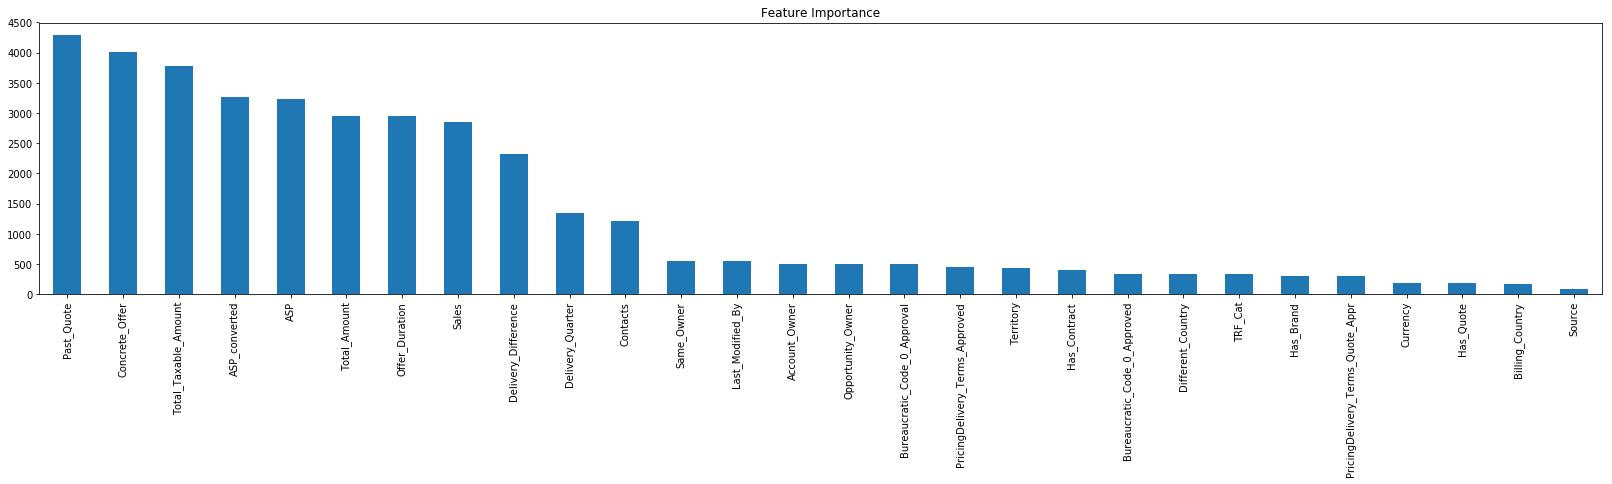

In [17]:
predictors = [x for x in x_train.drop(target, axis = 1).columns]
feat_imp = pd.Series(model.feature_importance(), predictors).sort_values(ascending = False)
feat_imp = feat_imp[0:28]
plt.rcParams['figure.figsize'] = 28, 5
feat_imp.plot(kind = 'bar', title = 'Feature Importance')

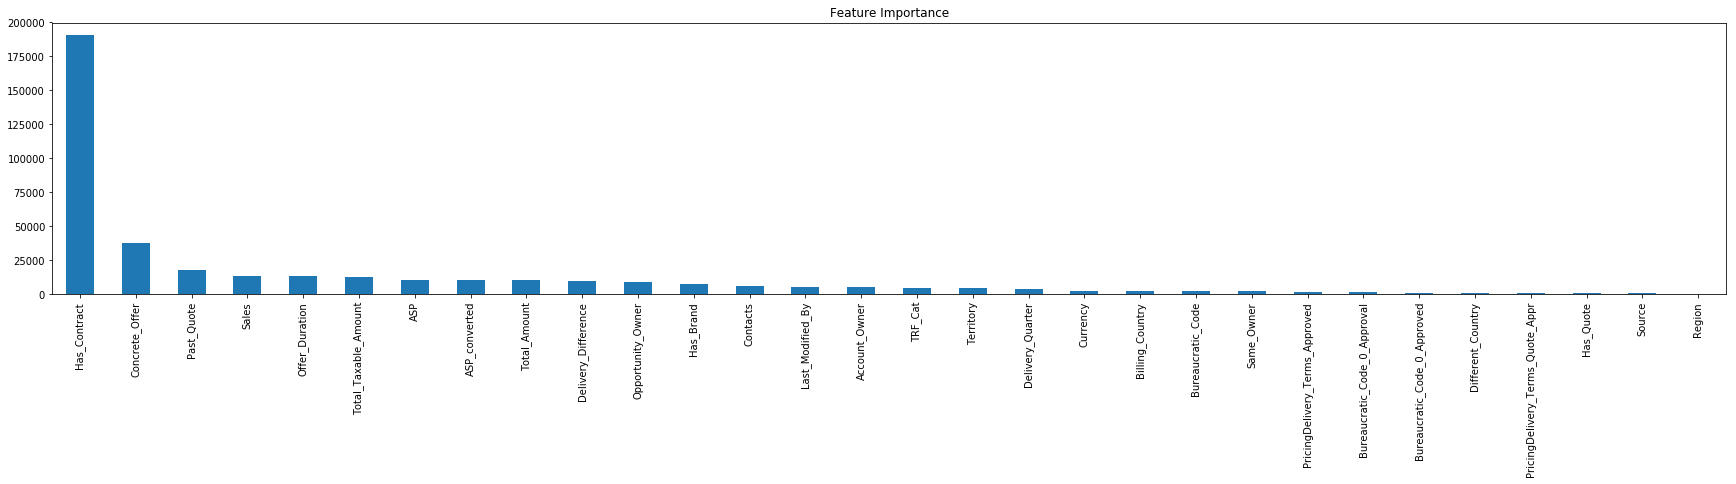

In [18]:
predictors = [x for x in x_train.drop(target, axis = 1).columns]
feat_imp = pd.Series(model.feature_importance("gain"), predictors).sort_values(ascending = False)
#feat_imp = feat_imp[0:30]
plt.rcParams['figure.figsize'] = 30, 5
feat_imp.plot(kind = 'bar', title = 'Feature Importance')

In [19]:
print feat_imp

Has_Contract                        190344.654370
Concrete_Offer                       37425.131543
Past_Quote                           17772.491167
Sales                                13538.491743
Offer_Duration                       13343.145921
Total_Taxable_Amount                 12733.436799
ASP                                  10573.066865
ASP_converted                        10346.832307
Total_Amount                         10273.871026
Delivery_Difference                  10093.530083
Opportunity_Owner                     9070.900924
Has_Brand                             7458.009275
Contacts                              6060.694461
Last_Modified_By                      5717.336061
Account_Owner                         5693.194234
TRF_Cat                               4586.773480
Territory                             4456.611777
Delivery_Quarter                      3667.034914
Currency                              2631.300732
Billing_Country                       2537.049795


In [56]:
y_pred = model.predict(x_test.drop(target, axis = 1))
pred = pd.DataFrame(y_pred, index = x_test.index, columns = ["Prediction"])
x_test_pred = x_test.join(pred)
x_test_pred["Max_pred"] = x_test_pred.groupby("Opportunity_ID", sort = False)["Prediction"].transform("max")
x_test_pred["Min_pred"] = x_test_pred.groupby("Opportunity_ID", sort = False)["Prediction"].transform("min")
x_test_pred["Mean_pred"] = x_test_pred.groupby("Opportunity_ID", sort = False)["Prediction"].transform("mean")
answer = x_test_pred.groupby("Opportunity_ID")["Stage","Prediction", "Max_pred", "Min_pred", "Mean_pred"].mean()

In [57]:
x_test_pred.loc[ (x_test_pred.Contacts > 1) & ( ((x_test_pred.Has_Contract == True) & (x_test_pred.Stage == 0)) | ( (x_test_pred.Has_Contract == False) & (x_test_pred.Stage == 1) ) ), ["Opportunity_ID", "Prediction", "Max_pred", "Min_pred", "Mean_pred", "Stage", "Has_Contract", "Territory"]].sort_values(by = "Opportunity_ID")

,Opportunity_ID,Prediction,Max_pred,Min_pred,Mean_pred,Stage,Has_Contract,Territory
70,27,0.983063,0.983063,0.983063,0.983063,1,False,United Kingdom
74,28,0.960578,0.960578,0.960578,0.960578,1,False,United Kingdom
639,292,0.039420,0.039420,0.039420,0.039420,0,True,None
2607,1451,0.263442,0.263442,0.263442,0.263442,0,True,France
4840,2874,0.213696,0.213696,0.205878,0.209787,0,True,Spain
4837,2874,0.205878,0.213696,0.205878,0.209787,0,True,Spain
5720,3535,0.526192,0.526192,0.526192,0.526192,0,True,Vietnam
6126,3785,0.110548,0.133295,0.110548,0.121922,0,True,China (PRC)
6129,3785,0.133295,0.133295,0.110548,0.121922,0,True,China (PRC)
6738,4166,0.823348,0.823348,0.652798,0.738073,0,True,Poland


In [37]:
log_loss(answer["Stage"], answer["Prediction"])

0.06591990822801334

In [22]:
validation_file = "Validacion_ECI_2020.csv"
vali = pd.read_csv(validation_file)
validation = preprocess(vali)

In [24]:
validation_file = "Validacion_ECI_2020.csv"
vali = pd.read_csv(validation_file)
validation = preprocess(vali)
leak = ["Opportunity_ID", "Sales_Contract_No"]
pred = model.predict(validation.drop(leak, axis = 1))

# agrupo por Opportunity_ID para dar una sola prediccion por solicitud

pred = pd.DataFrame(pred, index = validation.index, columns = ["Prediction"])
validation = validation.join(pred)

answer = pd.DataFrame(validation.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())
prev = pd.read_csv("acceptable/submission_11.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9930792403239315

In [30]:
data[(data.Billing_Country != data.Territory) & (data.Territory != "None")].groupby("Stage")["Stage"].count()

Stage
0    2323
1    2225
Name: Stage, dtype: int64

In [31]:
data["Different_Country"] = (data.Billing_Country != data.Territory) & (data.Territory != "None")

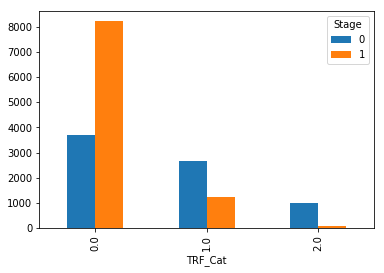

In [34]:
pd.crosstab(data.TRF_Cat, data.Stage).plot(kind = "bar")

In [7]:
df.groupby("Sales_Contract_No")["Sales_Contract_No"].count()

Sales_Contract_No
0          1
1          1
10         1
100        7
1000       1
1001       2
1002       1
1003       5
1004       5
1005       5
1006       5
1007       5
1008       1
1009       1
101        1
1010       2
1011       1
1012       1
1013       2
1014       1
1015       2
1016       2
1017       1
1018       2
1019       3
102        1
1020       1
1021       2
1022       1
1023       2
1024       2
1025       1
1026       2
1027       1
1028       2
1029       2
103        1
1030       2
1031       1
1032       1
1033       1
1034       1
1035       2
1036       1
1037       1
1038       1
1039       1
104        1
1040       1
1041       1
        ... 
954        2
955        1
956        1
958        1
959        1
96         1
960        1
961        1
962        1
963        1
964        1
965        1
966        1
967        1
968        1
969        1
97         3
970        1
971        1
972        1
973        1
974        1
975        1
976        2
977    

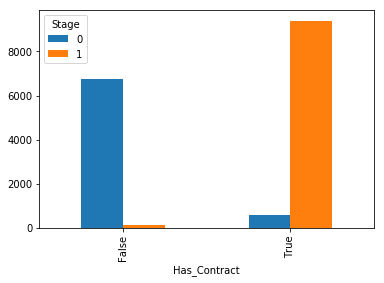

In [7]:
pd.crosstab(df.Has_Contract, df.Stage).plot(kind = "bar")

In [419]:
categorical = ['Region', 'Territory', 'Bureaucratic_Code', 'Source', 'Billing_Country', 'Account_Name', 
               'Opportunity_Name', 'Account_Owner', 'Opportunity_Owner', 'Account_Type', 'Last_Modified_By',
               'Opportunity_Type', 'Quote_Type', 'Delivery_Terms', 'Brand', 'Product_Type', 'Size',
               'Product_Category_B', 'Price', 'Currency', 'Last_Activity', 'Product_Family', 
               'Product_Name', 'ASP_Currency', 'ASP_converted_Currency', 'Month', 'Delivery_Quarter', 
               'Actual_Delivery_Date', 'Total_Amount_Currency', 'Total_Taxable_Amount_Currency', 'Prod_Category_A',
               'TRF_Cat']
categorical = [x for x in categorical if x in df.columns]

full_data = lgb.Dataset(df.drop(target, axis = 1), label = df.Stage, categorical_feature = categorical)

parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.6,
    'bagging_freq': 20,
    'learning_rate': 0.015,
    'max_bin': 400,
    'verbose': 0
}

full_model = lgb.train(parameters, full_data, num_boost_round = 5000)

In [420]:
validation_file = "Validacion_ECI_2020.csv"
vali = pd.read_csv(validation_file)
validation = preprocess(vali)
leak = ["Opportunity_ID", "Sales_Contract_No"]
pred = full_model.predict(validation.drop(leak, axis = 1))

# agrupo por Opportunity_ID para dar una sola prediccion por solicitud

pred = pd.DataFrame(pred, index = validation.index, columns = ["Prediction"])
validation = validation.join(pred)

answer2 = pd.DataFrame(validation.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())
prev = pd.read_csv("submission_11.csv")
prev["Prediction"].corr(answer2["Prediction"])

0.9910109044758247

In [421]:
answer2["Prediction"].corr(answer["Prediction"])

0.9923094924130285

In [527]:
answer.to_csv("submission_15.csv", header = False, index = False)

In [28]:
df["Product_Offer"] = df.groupby("Product_Family", sort = False)["Product_Family"].transform("count")

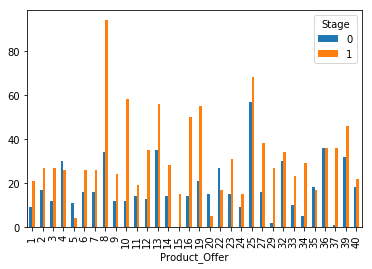

In [31]:
pd.crosstab(df[(df.Product_Offer <= 40) & (df.Product_Offer <= 40)].Product_Offer, df[(df.Product_Offer <= 40) & (df.Product_Offer <= 40)].Stage).plot(kind = "bar")

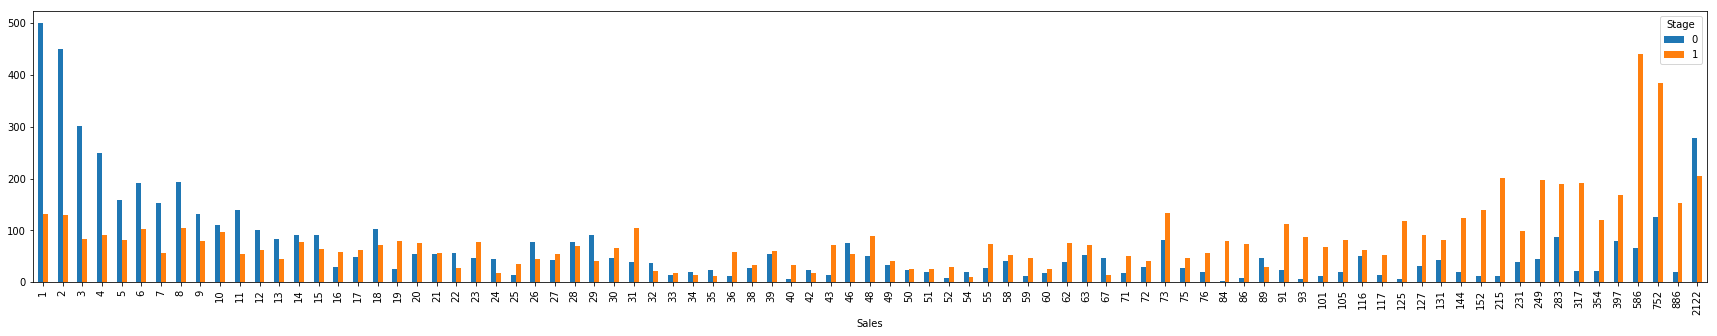

In [194]:
pd.crosstab(df.Sales, df.Stage).plot(kind = "bar")

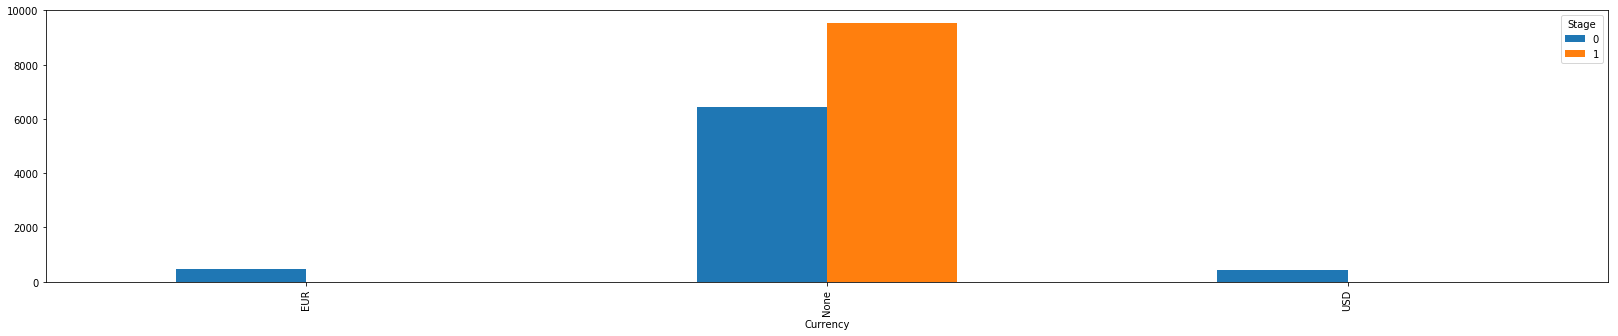

In [16]:
pd.crosstab(df.Currency, df.Stage).plot(kind = "bar")

In [246]:
dff = df.groupby("Opportunity_ID", as_index = False).max()

In [247]:
dff

,Opportunity_ID,PricingDelivery_Terms_Quote_Appr,PricingDelivery_Terms_Approved,Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,ASP,ASP_converted,Total_Amount,Total_Taxable_Amount,Stage,Contacts,Delivery_Difference,Same_Owner,Has_Brand,Has_Contract,Different_Country,TRF_Cat,Sales
0,0,1,1,1,1,0.5200,0.58817,5272800.00,5272800.00,0,1,60.0,True,False,False,False,2.0,63
1,1,0,0,0,0,0.5300,0.59948,48230.00,48230.00,1,1,2.0,True,False,True,False,0.0,63
2,2,0,0,0,0,0.4800,0.48000,83865.60,83865.60,1,1,0.0,True,False,True,True,0.0,91
3,3,1,0,1,0,0.5300,0.53000,7421881.50,7421881.50,0,1,58.0,True,True,False,True,2.0,8
4,4,1,0,1,0,0.5300,0.53000,13357192.50,13357192.50,0,1,27.0,True,True,False,True,2.0,8
5,5,1,0,1,0,0.5300,0.53000,14838277.50,14838277.50,0,1,58.0,True,True,False,True,2.0,8
6,6,1,0,1,0,0.3800,0.38000,2659494.60,2659494.60,0,1,89.0,True,False,False,True,1.0,8
7,7,1,1,1,1,0.4800,0.48000,50688.00,50688.00,1,1,0.0,True,False,False,True,0.0,91
8,8,1,0,0,0,78.0000,0.70125,304200.00,470400.00,0,5,0.0,True,False,False,False,0.0,2122
9,9,1,0,0,0,78.0000,0.70125,385320.00,559320.00,0,5,0.0,True,False,False,False,0.0,2122


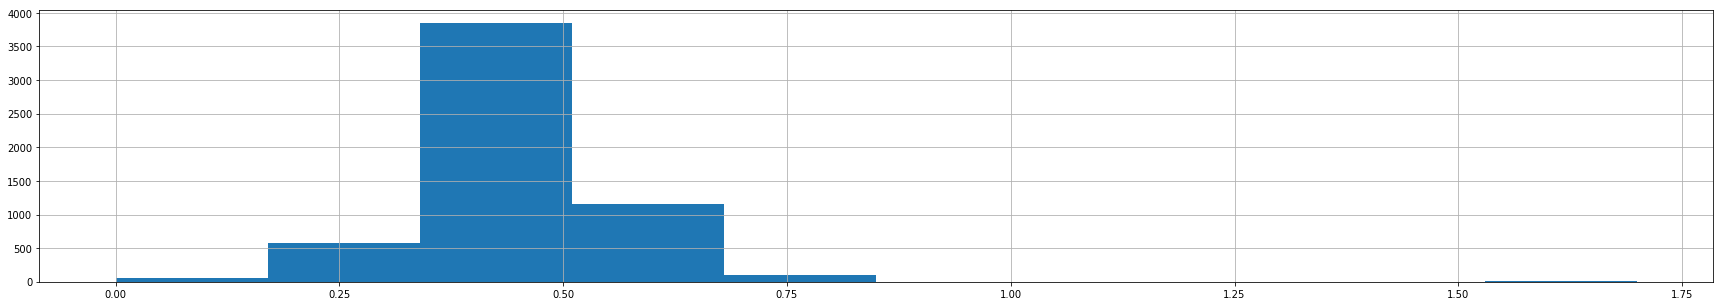

In [334]:
df[(df.Stage == 0) & (df.ASP_converted < 10)].ASP_converted.hist()

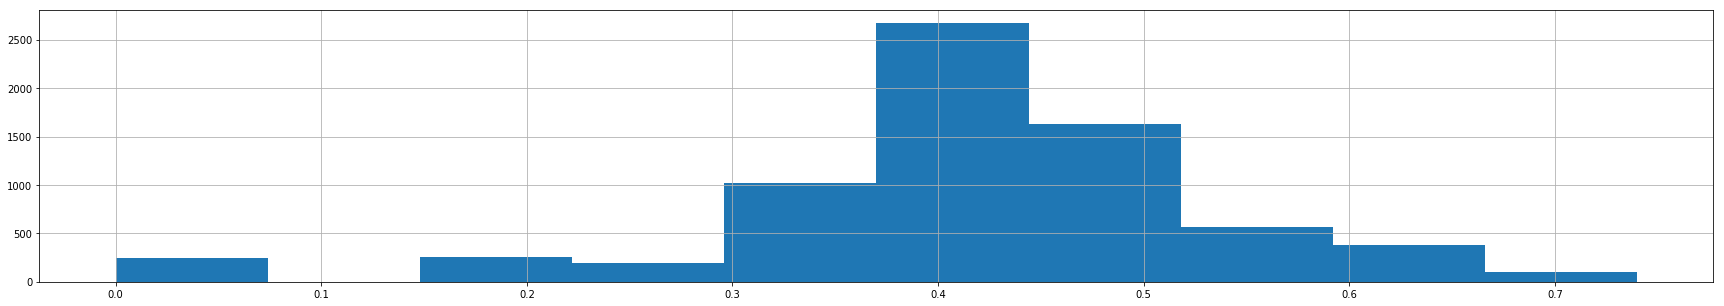

In [335]:
df[(df.Stage == 1) & (df.ASP_converted < 10)].ASP_converted.hist()

In [341]:
df[df.ASP >= 100]

,Region,Territory,PricingDelivery_Terms_Quote_Appr,PricingDelivery_Terms_Approved,Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Source,Billing_Country,Opportunity_ID,Sales_Contract_No,Account_Owner,Opportunity_Owner,Currency,ASP,ASP_converted,Delivery_Quarter,Total_Amount,Total_Taxable_Amount,Stage,Contacts,Delivery_Difference,Same_Owner,Has_Brand,Has_Contract,Different_Country,TRF_Cat,Sales


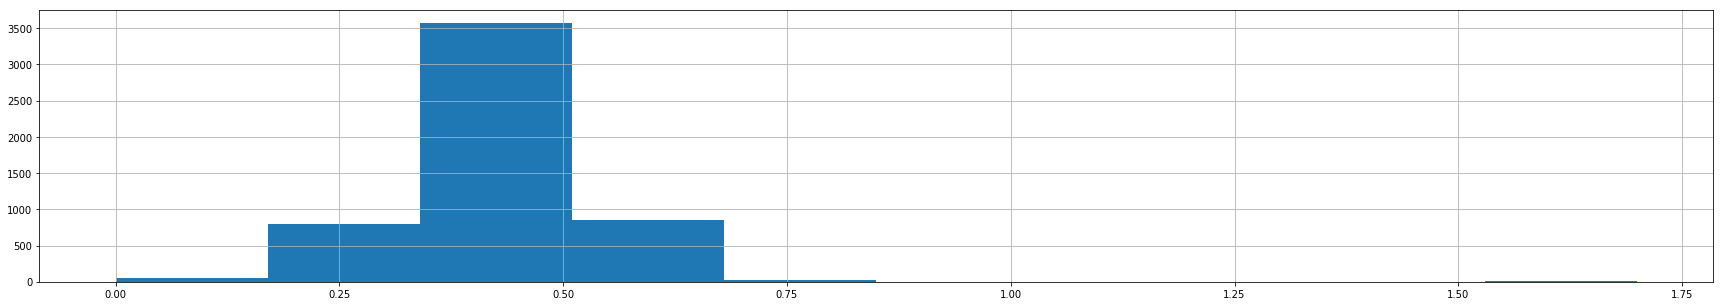

In [338]:
df[(df.Stage == 0) & (df.ASP < 10)].ASP.hist()

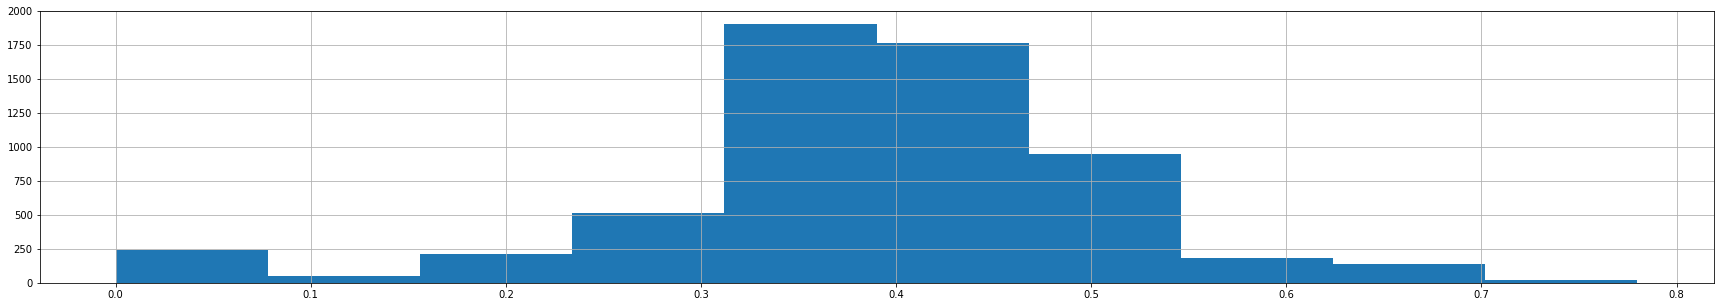

In [339]:
df[(df.Stage == 1) & (df.ASP < 10)].ASP.hist()

In [377]:
validation.loc[validation.Contacts > 1,["Opportunity_ID", "Total_Amount", "Prediction"]]

,Opportunity_ID,Total_Amount,Prediction
0,10689,162240.00,9.998427e-01
1,10689,78624.00,9.999800e-01
2,10689,126555.00,9.999641e-01
3,10690,243360.00,9.991531e-01
4,10690,157248.00,9.996472e-01
5,10690,126555.00,9.999089e-01
6,10690,118156.50,9.999394e-01
7,10690,112464.00,9.999438e-01
9,10692,342490.50,8.214472e-01
12,10692,456654.00,8.975898e-01


In [380]:
validation[(0.2 <= validation.Prediction) & (validation.Prediction <= 0.8)]

,Region,Territory,PricingDelivery_Terms_Quote_Appr,PricingDelivery_Terms_Approved,Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Source,Billing_Country,Opportunity_ID,Sales_Contract_No,Account_Owner,Opportunity_Owner,Currency,Last_Modified_By,ASP,ASP_converted,Delivery_Quarter,Total_Amount,Total_Taxable_Amount,Contacts,Delivery_Difference,Same_Owner,Has_Brand,Has_Contract,Different_Country,TRF_Cat,Sales,Prediction
74,Japan,Japan,1,1,0,0,Bureaucratic_Code_4,None,Japan,10730,None,Person_Name_55,Person_Name_55,None,Person_Name_28,0.000,0.00000,Q2,11020.00,11020.00,1,0.0,False,False,False,False,0.0,25,0.274020
106,EMEA,Germany,0,0,0,0,Bureaucratic_Code_4,None,Germany,10751,None,Person_Name_62,Person_Name_62,None,Person_Name_62,0.305,0.34498,Q2,229811.40,229811.40,1,5.0,True,False,False,False,1.0,3,0.530910
107,EMEA,Germany,0,0,0,0,Bureaucratic_Code_4,None,Germany,10752,None,Person_Name_62,Person_Name_62,None,Person_Name_62,0.305,0.34498,Q2,229811.40,229811.40,1,5.0,True,False,False,False,1.0,3,0.530910
108,EMEA,Germany,0,0,0,0,Bureaucratic_Code_4,None,Germany,10753,None,Person_Name_62,Person_Name_62,None,Person_Name_62,0.300,0.33933,Q2,135408.00,135408.00,1,18.0,True,False,False,False,0.0,3,0.244937
414,Americas,Central US,0,0,0,0,Bureaucratic_Code_4,None,United States,10935,5782,Person_Name_45,Person_Name_45,None,Person_Name_45,0.340,0.34000,Q2,67235.00,67235.00,1,0.0,True,False,True,True,0.0,6,0.715488
418,APAC,Philippines,0,0,0,0,Bureaucratic_Code_4,Source_11,Philippines,10938,6431,Person_Name_65,Person_Name_65,None,Person_Name_65,0.400,0.40000,Q2,400000.00,400000.00,1,60.0,True,False,True,False,1.0,1,0.649483
530,Americas,Central US,1,1,1,1,Bureaucratic_Code_4,None,United States,11002,5789,Person_Name_64,Person_Name_45,None,Person_Name_45,0.425,0.42500,Q1,125664.00,125664.00,1,NaN,True,False,True,True,0.0,2,0.716779
547,Americas,Central US,1,1,1,1,Bureaucratic_Code_4,None,United States,11011,5802,Person_Name_45,Person_Name_45,None,Person_Name_45,0.425,0.42500,Q1,44880.00,44880.00,1,0.0,True,False,True,True,0.0,2,0.625493
599,Americas,Central US,0,0,0,0,Bureaucratic_Code_4,None,United States,11048,6418,Person_Name_45,Person_Name_45,None,Person_Name_45,0.490,0.49000,Q2,45570.00,45570.00,1,NaN,True,False,True,True,0.0,2,0.698614
657,Americas,Central US,0,0,0,0,Bureaucratic_Code_4,None,United States,11085,5837,Person_Name_45,Person_Name_45,None,Person_Name_45,0.385,0.38500,Q1,67654.13,69222.13,2,NaN,True,False,True,True,0.0,3,0.325935


In [381]:
vali[vali.Opportunity_ID == 12308]

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,Opportunity_ID,Sales_Contract_No,Account_Owner,Opportunity_Owner,Account_Type,Opportunity_Type,Quote_Type,Delivery_Terms,Opportunity_Created_Date,Brand,Product_Type,Size,Product_Category_B,Price,Currency,Last_Activity,Quote_Expiry_Date,Last_Modified_Date,Last_Modified_By,Product_Family,Product_Name,ASP_Currency,ASP,ASP_(converted)_Currency,ASP_(converted),Planned_Delivery_Start_Date,Planned_Delivery_End_Date,Month,Delivery_Quarter,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Prod_Category_A
2474,7518,Americas,Central US,1,1,0,0,0,Bureaucratic_Code_4,8/11/2017,None,United States,Account_Name_156,Opportunity_Name_9042,12308,6495,Person_Name_45,Person_Name_45,Account_Type_2,Opportunity_Type_7,Non Binding,Delivery_Terms_6,4/23/2019,None,None,None,None,None,None,NaT,NaT,4/24/2019,Person_Name_45,Product_Family_168,Product_Name_322,USD,0.435,USD,0.435,10/1/2019,NaT,2019 - 10,Q4,2019,NaT,0,USD,64310.4,USD,64310.4,Prod_Category_A_None


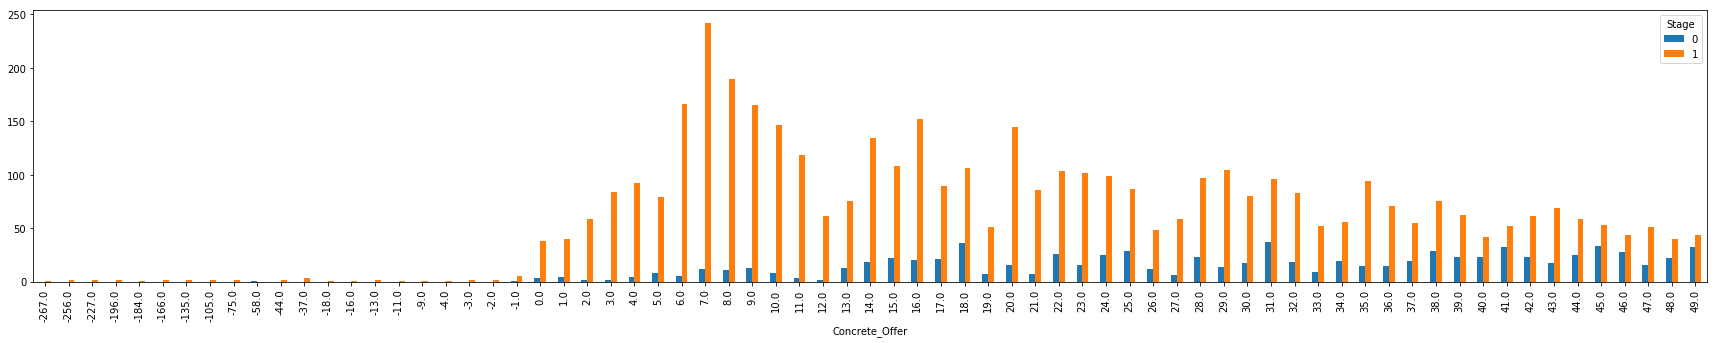

In [517]:
pd.crosstab(df[(df.Concrete_Offer < 50) & (df.Concrete_Offer < 50)].Concrete_Offer, df[(df.Concrete_Offer < 50) & (df.Concrete_Offer < 50)].Stage).plot(kind = "bar")

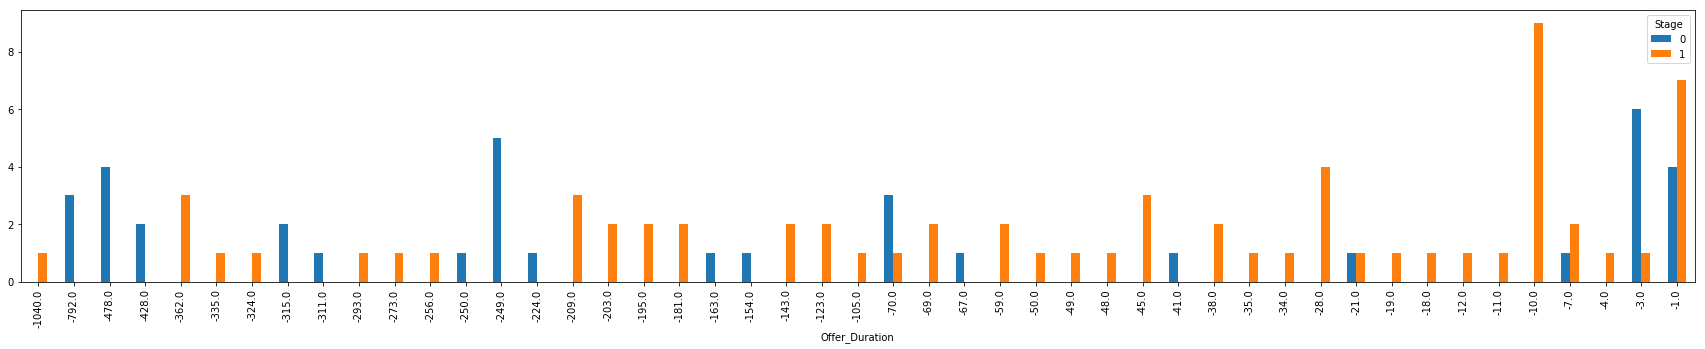

In [522]:
pd.crosstab(df[(df.Offer_Duration < 0) & (df.Offer_Duration < 0)].Offer_Duration, df[(df.Offer_Duration < 0) & (df.Offer_Duration < 0)].Stage).plot(kind = "bar")

In [481]:
full_data = lgb.Dataset(data = df.drop(target, axis = 1), label = df.Stage, categorical_feature = categorical)

cv_results = lgb.cv(parameters, full_data, num_boost_round = 1000, nfold = 5, early_stopping_rounds = 100)

In [483]:
cv_results["binary_logloss-mean"][-1]

0.07836245142644821

In [497]:
data.describe(include = "all")

,ID,Region,Territory,PricingDelivery_Terms_Quote_Appr,PricingDelivery_Terms_Approved,Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,Opportunity_ID,Sales_Contract_No,Account_Owner,Opportunity_Owner,Account_Type,Opportunity_Type,Quote_Type,Delivery_Terms,Opportunity_Created_Date,Brand,Product_Type,Size,Product_Category_B,Price,Currency,Last_Activity,Quote_Expiry_Date,Last_Modified_Date,Last_Modified_By,Product_Family,Product_Name,ASP_Currency,ASP,ASP_converted_Currency,ASP_converted,Planned_Delivery_Start_Date,Planned_Delivery_End_Date,Month,Delivery_Quarter,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A
count,16883.000000,16883,16883,16883.000000,16883.000000,16883.000000,16883.000000,16883.0,16883,16883,16883,16883,16883,16883,16883.000000,16883,16883,16883,16883,16883,16883,16883,16883,16883,16883,16883,16883,16883,16883,16883,16883,16883,16883,16883,16883,16883,13679.000000,16883,13679.000000,16883,16883,16883,16883,16883.000000,16883,16883.000000,16883,1.682400e+04,16883,1.688300e+04,16883.000000,16883
unique,NaN,5,75,NaN,NaN,NaN,NaN,NaN,7,800,14,79,1620,9791,NaN,5267,48,53,7,25,2,9,1096,26,7,7,28,53,3,1,996,649,53,225,446,5,NaN,1,NaN,968,1001,45,4,NaN,1,NaN,5,NaN,5,NaN,NaN,1
top,NaN,Japan,None,NaN,NaN,NaN,NaN,NaN,Bureaucratic_Code_4,4/20/2015,None,Japan,Account_Name_1888,Opportunity_Name_9795,NaN,None,Person_Name_50,Person_Name_50,Account_Type_2,Opportunity_Type_1,Non Binding,Delivery_Terms_4,6/30/2017,None,None,None,None,None,None,NaT,NaT,2/8/2018,Person_Name_47,Product_Family_77,Product_Name_100,USD,NaN,USD,NaN,3/31/2016,3/31/2016,2018 - 10,Q2,NaN,NaT,NaN,USD,NaN,USD,NaN,NaN,Prod_Category_A_None
freq,NaN,4869,4981,NaN,NaN,NaN,NaN,NaN,12544,3009,9454,4856,2122,36,NaN,6909,3722,3773,8786,6774,16713,7682,124,15847,15871,15903,15864,15918,15988,16883,4594,5820,8514,1345,976,7321,NaN,16883,NaN,381,451,666,4423,NaN,16883,NaN,7321,NaN,7305,NaN,NaN,16883
mean,17689.638453,NaN,NaN,0.807262,0.583249,0.473494,0.317538,0.0,NaN,NaN,NaN,NaN,NaN,NaN,5317.061956,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.977507,NaN,0.432941,NaN,NaN,NaN,NaN,2017.129657,NaN,2.335841,NaN,1.784533e+06,NaN,3.095833e+06,0.564651,NaN
std,6938.726406,NaN,NaN,0.394461,0.493035,0.499312,0.465533,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3316.269606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.849489,NaN,0.760244,NaN,NaN,NaN,NaN,0.820929,NaN,12.186565,NaN,1.302066e+07,NaN,1.854964e+07,0.495817,NaN
min,4854.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,2016.000000,NaN,0.000000,NaN,0.000000e+00,NaN,0.000000e+00,0.000000,NaN
25%,12013.500000,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2438.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.360000,NaN,0.375000,NaN,NaN,NaN,NaN,2016.000000,NaN,0.000000,NaN,2.660000e+04,NaN,8.540752e+04,0.000000,NaN
50%,18152.000000,NaN,NaN,1.000000,1.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,5295.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.400000,NaN,0.412850,NaN,NaN,NaN,NaN,2017.000000,NaN,0.000000,NaN,1.069790e+05,NaN,3.753945e+05,1.000000,NaN
75%,23900.500000,NaN,NaN,1.000000,1.000000,1.000000,1.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,7664.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.505000,NaN,0.476490,NaN,NaN,NaN,NaN,2018.000000,NaN,1.000000,NaN,4.540625e+05,NaN,1.031472e+06,1.000000,NaN


In [503]:
data.loc[data.Quote_Expiry_Date != "NaT", dates + ["Stage"]]

,Account_Created_Date,Opportunity_Created_Date,Quote_Expiry_Date,Last_Modified_Date,Planned_Delivery_Start_Date,Planned_Delivery_End_Date,Stage
0,6/16/2015,12/7/2015,1/30/2016,6/13/2016,5/1/2016,6/30/2016,0
1,6/16/2015,12/7/2015,1/20/2016,1/15/2016,1/18/2016,1/20/2016,1
2,4/21/2015,12/8/2015,9/30/2016,9/29/2016,1/25/2016,1/25/2016,1
4,7/27/2013,12/8/2015,6/2/2017,3/27/2018,2/1/2018,2/28/2018,0
5,7/27/2013,12/8/2015,6/2/2017,3/27/2018,2/1/2018,3/31/2018,0
7,4/21/2015,12/9/2015,1/7/2016,12/9/2015,1/25/2016,1/25/2016,1
23,10/13/2015,12/9/2015,3/31/2016,1/7/2016,1/9/2016,1/15/2016,1
24,12/9/2015,12/9/2015,3/31/2016,3/30/2016,1/18/2016,1/31/2016,0
62,7/27/2013,12/9/2015,12/23/2015,10/28/2016,4/11/2016,4/15/2016,0
63,7/27/2013,12/9/2015,1/8/2016,12/9/2015,1/18/2016,1/29/2016,1


In [27]:
from sklearn.calibration import calibration_curve
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_pred, n_bins = 30)

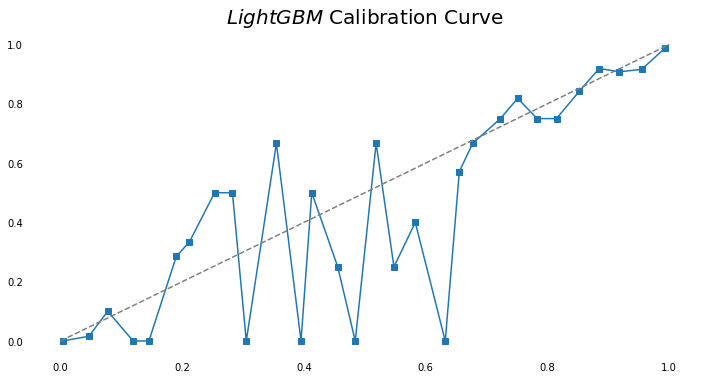

In [28]:
pltt = plt.pyplot
fig, ax = pltt.subplots(1, figsize = (12, 6))
pltt.plot(mean_predicted_value, fraction_of_positives, 's-')
pltt.plot([0, 1], [0, 1], '--', color = 'gray')

sns.despine(left = True, bottom = True)
pltt.gca().xaxis.set_ticks_position('none')
pltt.gca().yaxis.set_ticks_position('none')
pltt.title("$LightGBM$ Calibration Curve", fontsize = 20); pass

In [26]:
from sklearn.metrics import confusion_matrix
y_pred_def = np.where(y_pred > 0.5, 1, 0)
confusion_matrix(y_test, y_pred_def)

array([[1694,   73],
       [  12, 2189]])

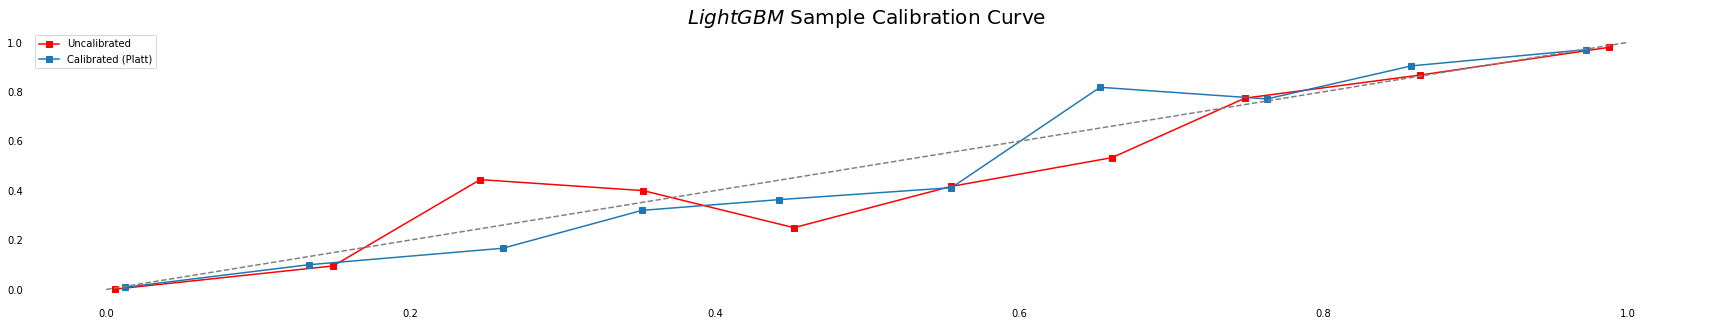

In [55]:
from sklearn.calibration import CalibratedClassifierCV
pltt = plt.pyplot

fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_pred, n_bins = 10)

pltt.plot(mean_predicted_value, fraction_of_positives, 's-', color='red', label='Uncalibrated')

# Create a corrected classifier.
clf = lgb.LGBMClassifier().set_params(**parameters)
clf_sigmoid = CalibratedClassifierCV(clf, cv = 5, method = 'isotonic')
clf_sigmoid.fit(x_train.drop(target + cat_vars, axis = 1), y_train)
y_test_predict_proba = clf_sigmoid.predict_proba(x_test.drop(target + cat_vars + ["Prediction"], axis = 1))[:,1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_test_predict_proba, n_bins = 10)

pltt.plot(mean_predicted_value, fraction_of_positives, 's-', label='Calibrated (Platt)')
pltt.plot([0, 1], [0, 1], '--', color='gray')

sns.despine(left=True, bottom=True)
pltt.gca().xaxis.set_ticks_position('none')
pltt.gca().yaxis.set_ticks_position('none')
pltt.gca().legend()
pltt.title("$LightGBM$ Sample Calibration Curve", fontsize=20); pass

In [38]:
cat_vars = [x for x in x_train.select_dtypes('category').columns if x != 'Stage']

In [56]:
y_test_predict_proba

array([0.        , 0.        , 0.98725389, ..., 0.99173075, 0.04271839,
       0.03160151])

In [57]:
log_loss(y_test, y_test_predict_proba)

0.11978329486208197

In [77]:
y_pred = model.predict(x_train.drop(target, axis = 1))
pred = pd.DataFrame(y_pred, index = x_train.index, columns = ["Prediction"])
x_t = x_train.join(pred)
ans = x_t.groupby("Opportunity_ID")["Stage","Prediction"].mean()
log_loss(ans["Stage"], ans["Prediction"])

0.016727998980082245

In [81]:
train_data = lgb.Dataset(x_t.drop(target, axis = 1), label = y_train, categorical_feature = categorical)
test_data = lgb.Dataset(x_ttest.drop(target, axis = 1), label = y_test)

parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 20,
    'feature_fraction': 0.4,
    'bagging_fraction': 0.6,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'max_bin': 200,
    'verbose': 0
}

model2 = lgb.train(parameters, train_data, valid_sets = test_data, num_boost_round = 500, early_stopping_rounds = 100)

[1]	valid_0's binary_logloss: 0.645296
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.631906
[3]	valid_0's binary_logloss: 0.591042
[4]	valid_0's binary_logloss: 0.558183
[5]	valid_0's binary_logloss: 0.523974
[6]	valid_0's binary_logloss: 0.492772
[7]	valid_0's binary_logloss: 0.464137
[8]	valid_0's binary_logloss: 0.43781
[9]	valid_0's binary_logloss: 0.416525
[10]	valid_0's binary_logloss: 0.393945
[11]	valid_0's binary_logloss: 0.373017
[12]	valid_0's binary_logloss: 0.356031
[13]	valid_0's binary_logloss: 0.348297
[14]	valid_0's binary_logloss: 0.333106
[15]	valid_0's binary_logloss: 0.319053
[16]	valid_0's binary_logloss: 0.31422
[17]	valid_0's binary_logloss: 0.308857
[18]	valid_0's binary_logloss: 0.296125
[19]	valid_0's binary_logloss: 0.291494
[20]	valid_0's binary_logloss: 0.286778
[21]	valid_0's binary_logloss: 0.281735
[22]	valid_0's binary_logloss: 0.276966
[23]	valid_0's binary_logloss: 0.264012
[24]	valid_0's binary_logloss

[201]	valid_0's binary_logloss: 0.106693
[202]	valid_0's binary_logloss: 0.107462
[203]	valid_0's binary_logloss: 0.107618
[204]	valid_0's binary_logloss: 0.107702
[205]	valid_0's binary_logloss: 0.108227
[206]	valid_0's binary_logloss: 0.108436
[207]	valid_0's binary_logloss: 0.108372
[208]	valid_0's binary_logloss: 0.108363
[209]	valid_0's binary_logloss: 0.109133
[210]	valid_0's binary_logloss: 0.109905
Early stopping, best iteration is:
[110]	valid_0's binary_logloss: 0.0851935


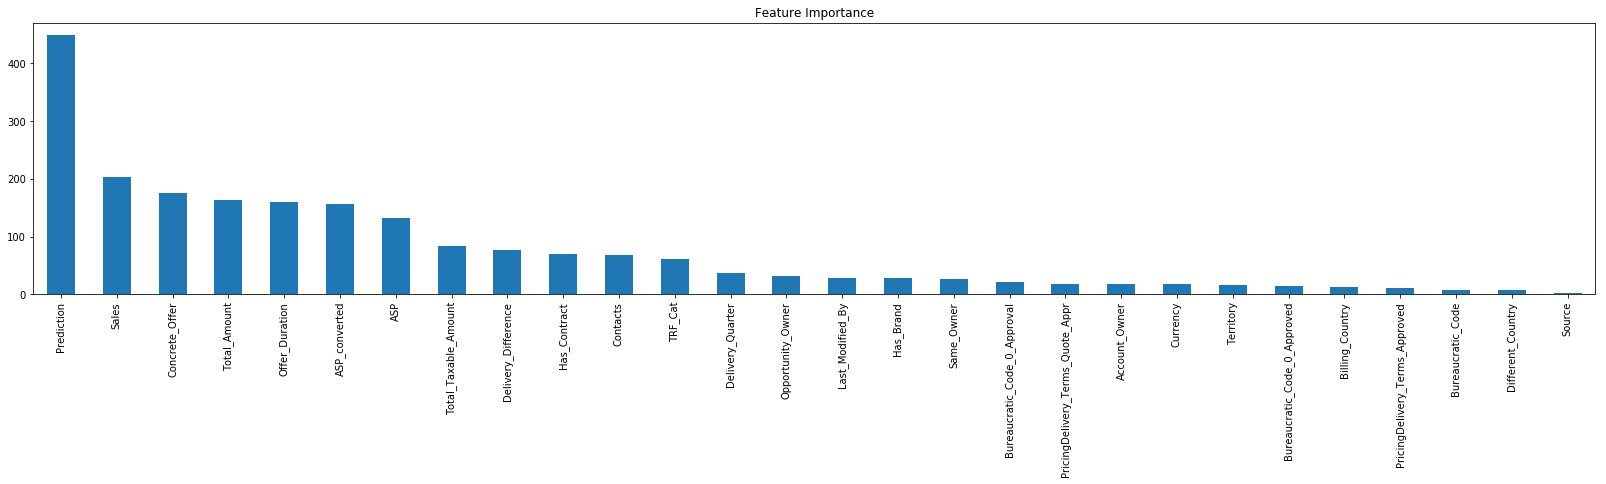

In [63]:
predictors = [x for x in x_t.drop(target, axis = 1).columns]
feat_imp = pd.Series(model.feature_importance(), predictors).sort_values(ascending = False)
feat_imp = feat_imp[0:28]
plt.rcParams['figure.figsize'] = 28, 5
feat_imp.plot(kind = 'bar', title = 'Feature Importance')

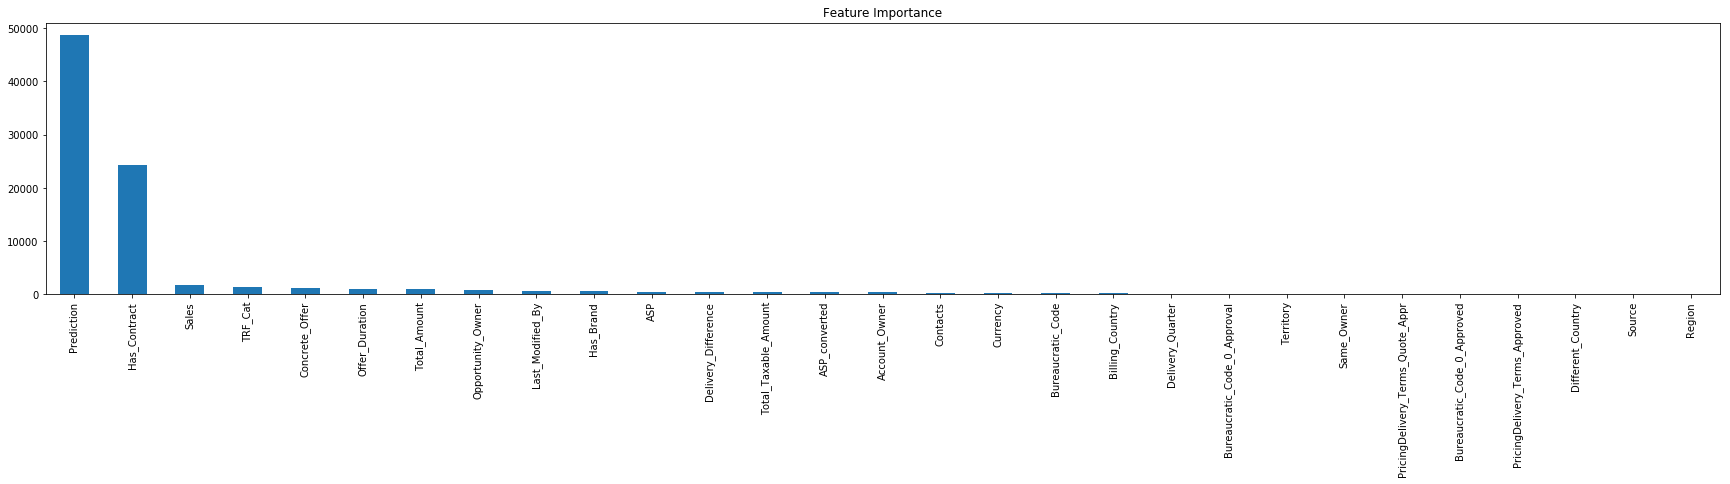

In [83]:
predictors = [x for x in x_t.drop(target, axis = 1).columns]
feat_imp = pd.Series(model2.feature_importance("gain"), predictors).sort_values(ascending = False)
#feat_imp = feat_imp[0:30]
plt.rcParams['figure.figsize'] = 30, 5
feat_imp.plot(kind = 'bar', title = 'Feature Importance')

In [84]:
print feat_imp

Prediction                          48631.298288
Has_Contract                        24341.033149
Sales                                1793.079609
TRF_Cat                              1340.167082
Concrete_Offer                       1131.505506
Offer_Duration                        987.043741
Total_Amount                          925.796565
Opportunity_Owner                     738.413982
Last_Modified_By                      683.328958
Has_Brand                             627.758631
ASP                                   455.858315
Delivery_Difference                   392.692549
Total_Taxable_Amount                  390.804296
ASP_converted                         379.402830
Account_Owner                         358.138387
Contacts                              308.125735
Currency                              248.791013
Bureaucratic_Code                     224.405248
Billing_Country                       197.517623
Delivery_Quarter                      135.226170
Bureaucratic_Code_0_

In [85]:
y_pred = model2.predict(x_ttest.drop(target, axis = 1))
pred = pd.DataFrame(y_pred, index = x_ttest.index, columns = ["Def_Prediction"])
aux = x_ttest.join(pred)
answer = aux.groupby("Opportunity_ID")["Stage","Def_Prediction"].mean()
log_loss(answer.Stage, answer.Def_Prediction)

0.0909961823711311

In [87]:
validation_file = "Validacion_ECI_2020.csv"
vali = pd.read_csv(validation_file)
validation = preprocess(vali)
leak = ["Opportunity_ID", "Sales_Contract_No"]
pred = model.predict(validation.drop(leak, axis = 1))

# agrupo por Opportunity_ID para dar una sola prediccion por solicitud

pred = pd.DataFrame(pred, index = validation.index, columns = ["Prediction"])
validation = validation.join(pred)

def_pred = model2.predict(validation.drop(leak, axis = 1))
def_pred = pd.DataFrame(def_pred, index = validation.index, columns = ["Def_Prediction"])
aux = validation.join(def_pred)
answer = pd.DataFrame(aux.groupby("Opportunity_ID", as_index = False)["Def_Prediction"].mean())
prev = pd.read_csv("submission_11.csv")
prev["Prediction"].corr(answer["Def_Prediction"])

0.9865961854833982

In [1]:
answer[(answer.Def_Prediction >= 0.1) & (answer.Def_Prediction <= 0.9)]

NameError: name 'answer' is not defined

In [89]:
answer.to_csv("submission_20.csv", header = False, index = False)

In [40]:
x_ttest[(x_ttest.Prediction > 0.5) & (x_ttest.Stage == 0) | (x_ttest.Prediction < 0.5) & (x_ttest.Stage == 1)]

,Region,Territory,PricingDelivery_Terms_Quote_Appr,PricingDelivery_Terms_Approved,Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Source,Billing_Country,Opportunity_ID,Sales_Contract_No,Account_Owner,Opportunity_Owner,Currency,Last_Modified_By,ASP,ASP_converted,Delivery_Quarter,Total_Amount,Total_Taxable_Amount,Stage,Contacts,Delivery_Difference,Concrete_Offer,Offer_Duration,Same_Owner,Has_Brand,Has_Contract,Different_Country,TRF_Cat,Sales,Prediction
16729,EMEA,Denmark,0,0,0,0,Bureaucratic_Code_4,Source_9,Germany,12702,None,Person_Name_13,Person_Name_13,None,Person_Name_13,0.5300,0.59948,Q1,310050.00,310050.00,1,1,39.0,112.0,55.0,True,False,False,True,1.0,283,0.452048
16676,Americas,NW America,1,1,1,1,Bureaucratic_Code_4,Source_11,United States,12666,None,Person_Name_64,Person_Name_8,None,Person_Name_8,0.6800,0.68000,Q1,1309000.00,1309000.00,0,1,0.0,154.0,15.0,True,False,False,True,1.0,43,0.840753
374,EMEA,Germany,1,1,0,0,Bureaucratic_Code_4,Source_9,Germany,154,30,Person_Name_4,Person_Name_4,None,Person_Name_47,0.5200,0.58817,Q2,4375800.00,4375800.00,0,1,73.0,175.0,67.0,False,False,True,False,2.0,28,0.828167
8889,Americas,NW America,1,1,0,0,Bureaucratic_Code_4,Source_11,United States,5535,2680,Person_Name_8,Person_Name_8,None,Person_Name_47,0.3875,0.38750,Q4,78662.50,78662.50,0,1,0.0,86.0,54.0,False,False,True,True,0.0,728,0.551602
9431,EMEA,Netherlands,0,0,0,0,Bureaucratic_Code_4,Source_7,Netherlands,5965,2967,Person_Name_18,Person_Name_18,None,Person_Name_47,0.4350,0.49203,Q3,96243.75,96243.75,0,1,0.0,39.0,4.0,False,False,True,False,0.0,50,0.989461
5654,Japan,None,1,1,0,0,Bureaucratic_Code_4,None,Japan,3476,1160,Person_Name_50,Person_Name_50,None,Person_Name_50,57.0000,0.51245,Q2,741000.00,741000.00,0,1,0.0,135.0,1.0,True,False,True,False,0.0,354,0.537324
10414,APAC,Australia,0,0,0,0,Bureaucratic_Code_4,Source_9,Australia,6518,3441,Person_Name_43,Person_Name_43,None,Person_Name_47,0.4000,0.40000,Q4,91080.00,728640.00,0,2,14.0,38.0,NaN,False,False,True,False,0.0,248,0.961888
12869,Americas,NW America,1,0,1,0,Bureaucratic_Code_5,Source_9,United States,7803,3964,Person_Name_64,Person_Name_64,None,Person_Name_64,0.4550,0.45500,Q3,71662.50,73362.50,0,2,30.0,190.0,6.0,True,False,True,True,0.0,12,0.641017
8888,Americas,NW America,1,1,0,0,Bureaucratic_Code_4,Source_11,United States,5534,2679,Person_Name_8,Person_Name_8,None,Person_Name_47,0.3875,0.38750,Q4,78662.50,157325.00,0,2,0.0,121.0,54.0,False,False,True,True,0.0,728,0.550971
13394,APAC,India,1,1,1,1,Bureaucratic_Code_4,Source_7,India,8130,4411,Person_Name_59,Person_Name_59,None,Person_Name_59,0.3480,0.34800,Q3,80388.00,80388.00,0,1,6.0,86.0,38.0,True,False,True,False,0.0,6,0.651798


In [43]:
df[(~df.Has_Contract) & (df.Stage == 1)].describe(include = "all")

,Region,Territory,PricingDelivery_Terms_Quote_Appr,PricingDelivery_Terms_Approved,Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Source,Billing_Country,Opportunity_ID,Sales_Contract_No,Account_Owner,Opportunity_Owner,Currency,Last_Modified_By,ASP,ASP_converted,Delivery_Quarter,Total_Amount,Total_Taxable_Amount,Stage,Contacts,Delivery_Difference,Concrete_Offer,Offer_Duration,Same_Owner,Has_Brand,Has_Contract,Different_Country,TRF_Cat,Sales
count,132,132,132.000000,132.000000,132.000000,132.000000,132,132,132,132.000000,132,132,132,132,132,132.000000,132.000000,132,1.310000e+02,1.320000e+02,132.0,132.000000,132.000000,132.000000,115.000000,132,132,132,132,132.000000,132.000000
unique,5,17,NaN,NaN,NaN,NaN,3,6,14,NaN,1,20,21,1,19,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1,1,2,NaN,NaN
top,EMEA,Germany,NaN,NaN,NaN,NaN,Bureaucratic_Code_4,None,Germany,NaN,None,Person_Name_13,Person_Name_13,None,Person_Name_13,NaN,NaN,Q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,False,NaN,NaN
freq,74,33,NaN,NaN,NaN,NaN,106,59,46,NaN,132,33,29,132,24,NaN,NaN,86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84,132,132,89,NaN,NaN
mean,NaN,NaN,0.636364,0.446970,0.363636,0.242424,NaN,NaN,NaN,8765.689394,NaN,NaN,NaN,NaN,NaN,9.623379,0.536029,NaN,4.372741e+06,1.594923e+07,1.0,1.977273,20.416667,133.462121,61.886957,NaN,NaN,NaN,NaN,0.500000,122.083333
std,NaN,NaN,0.482878,0.499074,0.482878,0.430182,NaN,NaN,NaN,4860.471989,NaN,NaN,NaN,NaN,NaN,23.293126,0.166311,NaN,1.990922e+07,4.601821e+07,0.0,1.753800,36.322987,155.160857,90.867627,NaN,NaN,NaN,NaN,0.671105,268.280047
min,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,7.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,3.575000e+03,0.000000e+00,1.0,1.000000,0.000000,0.000000,-1.000000,NaN,NaN,NaN,NaN,0.000000,1.000000
25%,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,5723.500000,NaN,NaN,NaN,NaN,NaN,0.417500,0.452440,NaN,7.734375e+04,1.072500e+05,1.0,1.000000,3.000000,42.500000,13.000000,NaN,NaN,NaN,NaN,0.000000,34.000000
50%,NaN,NaN,1.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,12372.000000,NaN,NaN,NaN,NaN,NaN,0.535000,0.599480,NaN,2.644800e+05,3.727620e+05,1.0,1.000000,11.000000,78.500000,30.000000,NaN,NaN,NaN,NaN,0.000000,58.000000
75%,NaN,NaN,1.000000,1.000000,1.000000,0.000000,NaN,NaN,NaN,12697.250000,NaN,NaN,NaN,NaN,NaN,0.680000,0.641130,NaN,2.104050e+06,2.674912e+06,1.0,2.000000,29.000000,136.000000,66.500000,NaN,NaN,NaN,NaN,1.000000,116.000000


In [44]:
df[(~df.Has_Contract) & (df.Stage == 0)].describe(include = "all")

,Region,Territory,PricingDelivery_Terms_Quote_Appr,PricingDelivery_Terms_Approved,Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Source,Billing_Country,Opportunity_ID,Sales_Contract_No,Account_Owner,Opportunity_Owner,Currency,Last_Modified_By,ASP,ASP_converted,Delivery_Quarter,Total_Amount,Total_Taxable_Amount,Stage,Contacts,Delivery_Difference,Concrete_Offer,Offer_Duration,Same_Owner,Has_Brand,Has_Contract,Different_Country,TRF_Cat,Sales
count,5510,5510,5510.000000,5510.000000,5510.000000,5510.000000,5510,5510,5510,5510.000000,5510,5510,5510,5510,5510,5503.000000,5503.000000,5510,5.452000e+03,5.510000e+03,5510.0,5510.000000,5483.000000,5483.000000,3733.000000,5510,5510,5510,5510,5510.000000,5510.000000
unique,5,72,NaN,NaN,NaN,NaN,5,14,76,NaN,1,48,52,3,51,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,1,2,NaN,NaN
top,EMEA,None,NaN,NaN,NaN,NaN,Bureaucratic_Code_4,None,United States,NaN,None,Person_Name_3,Person_Name_3,None,Person_Name_47,NaN,NaN,Q3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,False,NaN,NaN
freq,2092,931,NaN,NaN,NaN,NaN,3499,2706,1590,NaN,5510,593,544,4746,2104,NaN,NaN,1429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2811,4637,5510,3590,NaN,NaN
mean,NaN,NaN,0.837750,0.520327,0.652269,0.394011,NaN,NaN,NaN,5274.309800,NaN,NaN,NaN,NaN,NaN,5.429597,0.450547,NaN,3.968936e+06,5.787953e+06,0.0,2.309437,51.833121,197.842787,77.762657,NaN,NaN,NaN,NaN,0.813793,161.223593
std,NaN,NaN,0.368714,0.499632,0.476293,0.488682,NaN,NaN,NaN,3462.814656,NaN,NaN,NaN,NaN,NaN,17.505818,0.780825,NaN,2.167819e+07,2.425296e+07,0.0,3.360513,939.720367,948.212650,99.120075,NaN,NaN,NaN,NaN,0.713044,471.107162
min,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000e+00,0.000000e+00,0.0,1.000000,0.000000,0.000000,-1.000000,NaN,NaN,NaN,NaN,0.000000,1.000000
25%,NaN,NaN,1.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,2344.250000,NaN,NaN,NaN,NaN,NaN,0.360000,0.373260,NaN,1.501500e+05,1.014000e+05,0.0,1.000000,4.000000,78.000000,23.000000,NaN,NaN,NaN,NaN,0.000000,4.000000
50%,NaN,NaN,1.000000,1.000000,1.000000,0.000000,NaN,NaN,NaN,4873.500000,NaN,NaN,NaN,NaN,NaN,0.390000,0.412850,NaN,4.730360e+05,4.391200e+05,0.0,1.000000,21.000000,142.000000,44.000000,NaN,NaN,NaN,NaN,1.000000,14.000000
75%,NaN,NaN,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,7799.750000,NaN,NaN,NaN,NaN,NaN,0.500000,0.495000,NaN,2.249888e+06,2.436427e+06,0.0,2.000000,52.000000,252.000000,99.000000,NaN,NaN,NaN,NaN,1.000000,51.000000


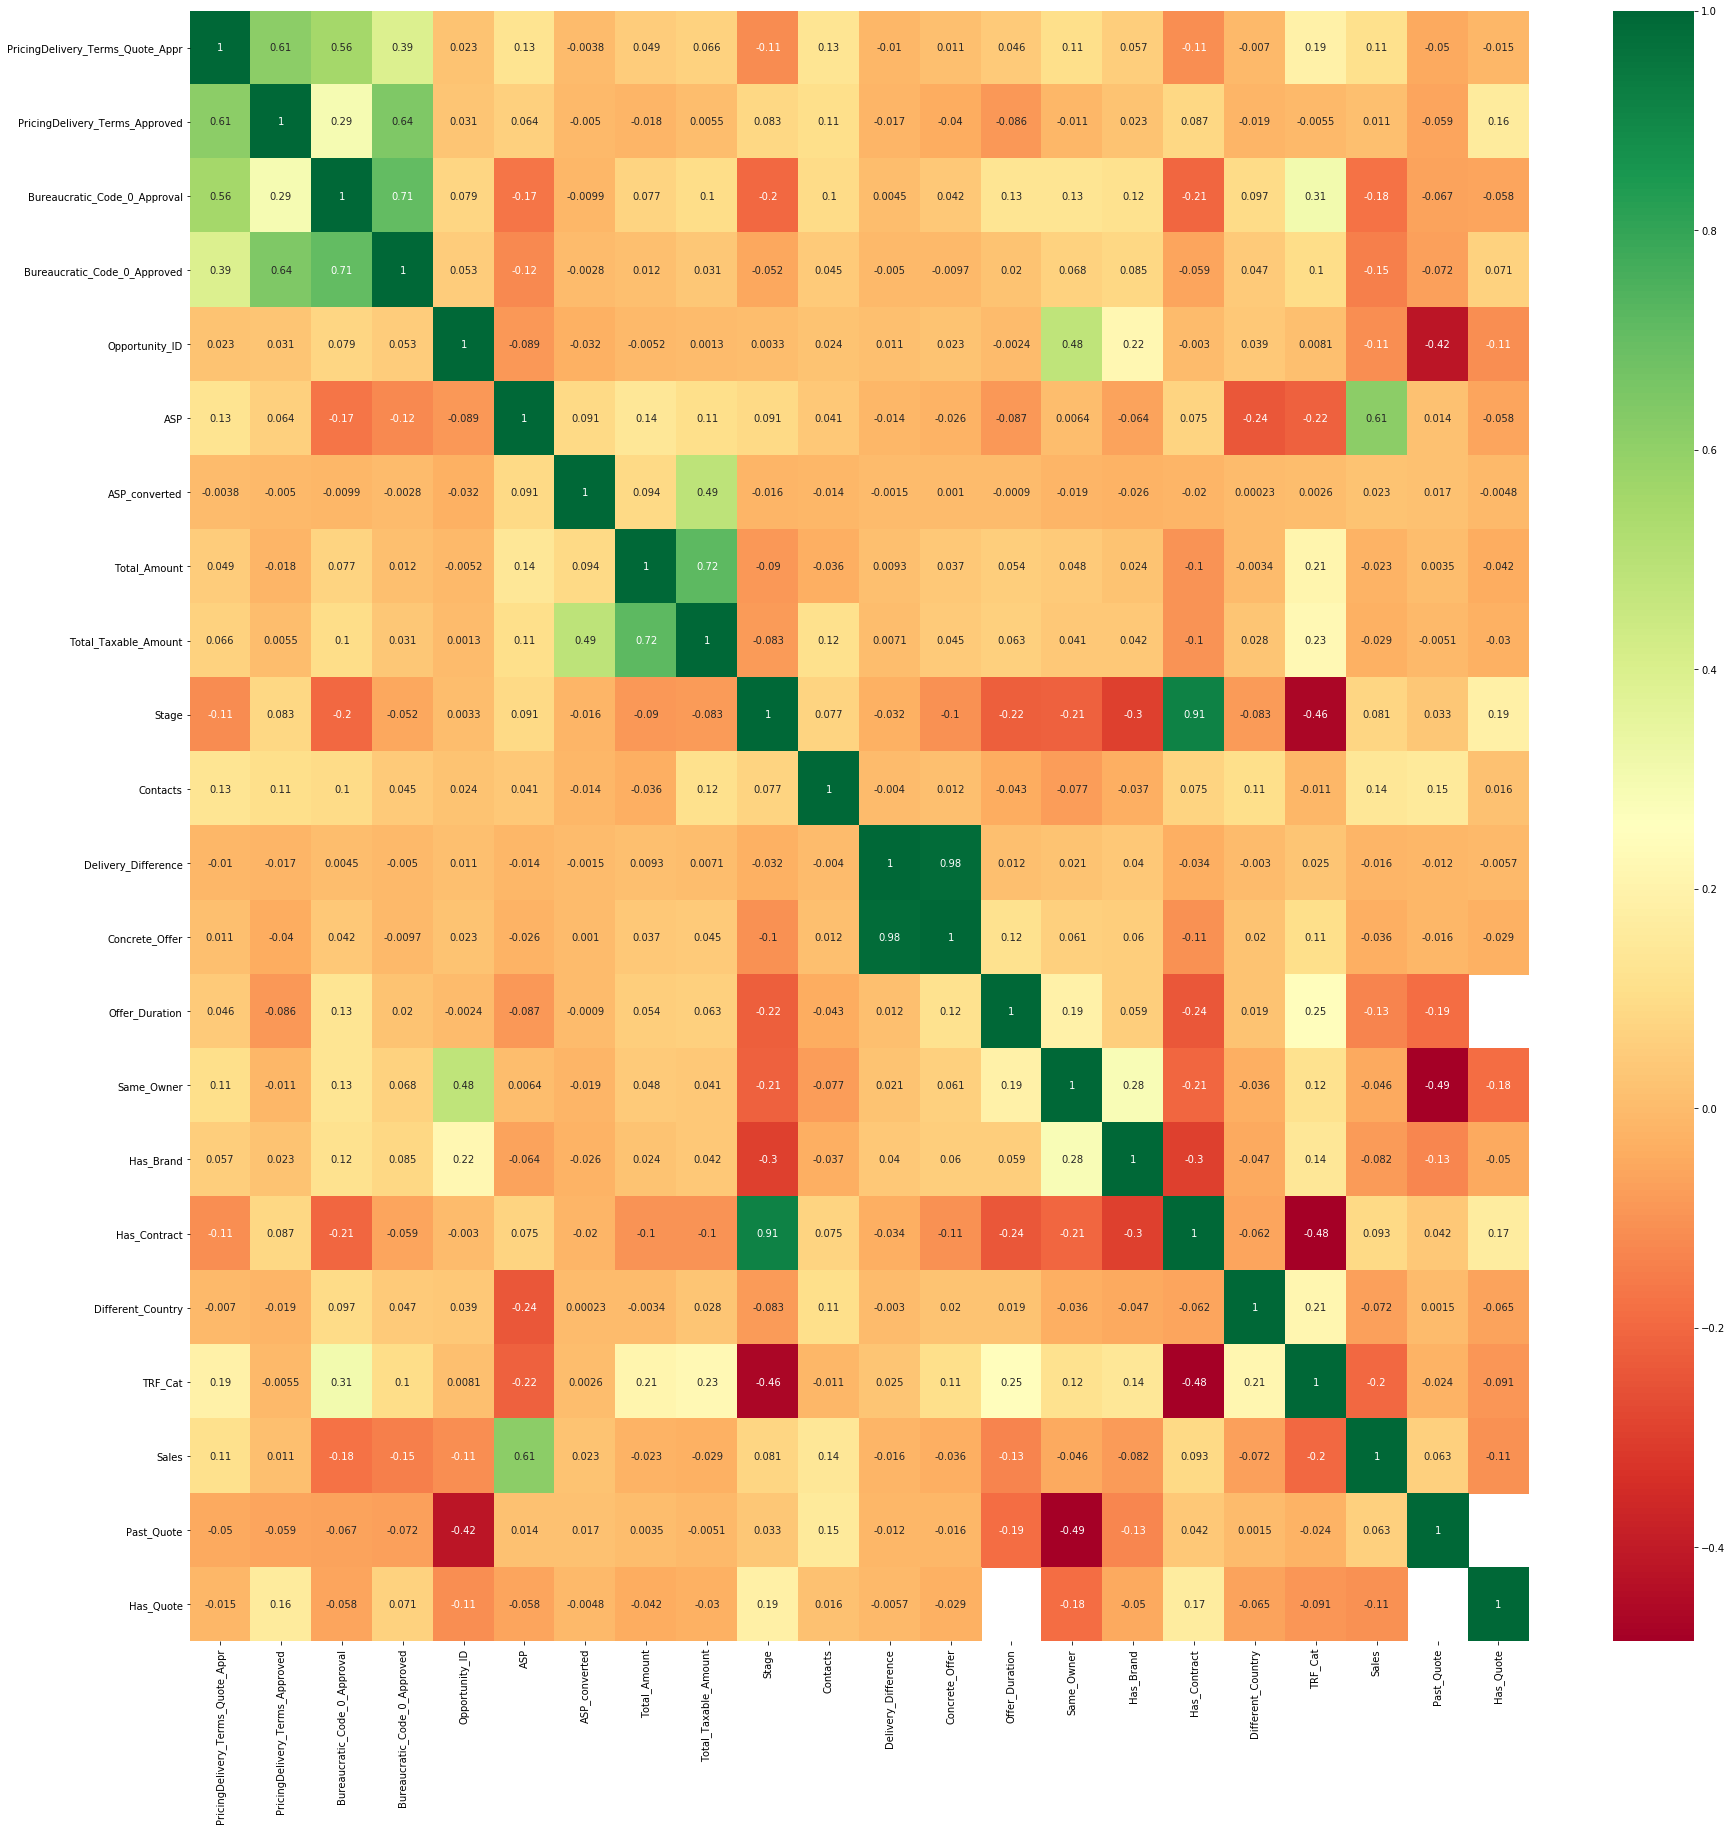

In [66]:
import seaborn as sns

cols = [c for c in df.drop(target + ["Opportunity_ID", "Sales_Contract_No"], axis = 1).columns]

X = df[cols]  #independent columns
y = df["Stage"]    #target column i.e price range
#get correlations of each features in dataset
corrmat = df.corr()
top_corr_features = corrmat.index
plt.pyplot.figure(figsize = (30,30))
#plot heat map
g = sns.heatmap(df[top_corr_features].corr(), annot = True, cmap = "RdYlGn")

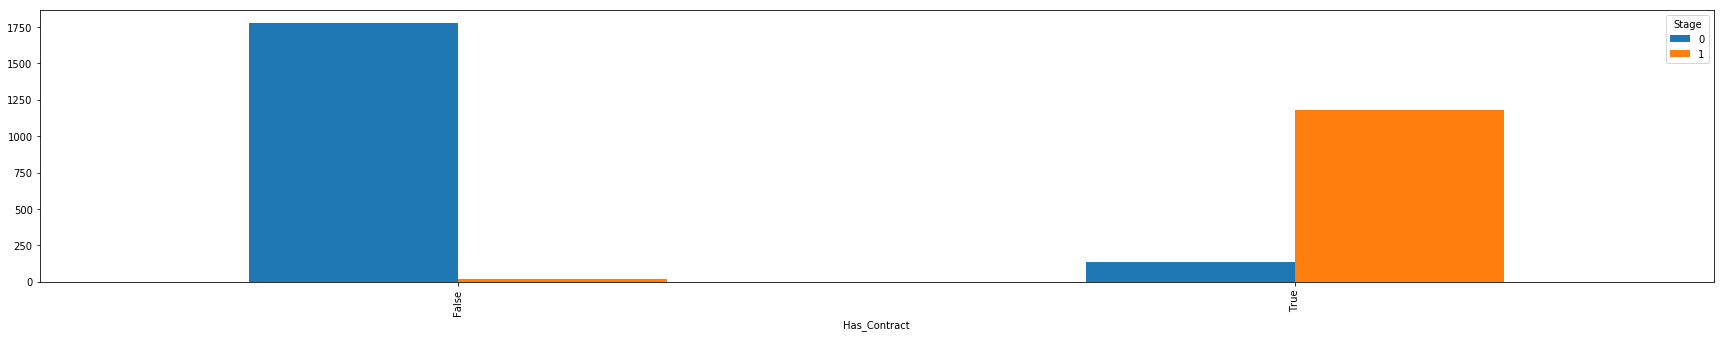

In [61]:
pd.crosstab(df[df.Offer_Duration.isna()].Has_Contract, df[df.Offer_Duration.isna()].Stage).plot(kind = "bar")

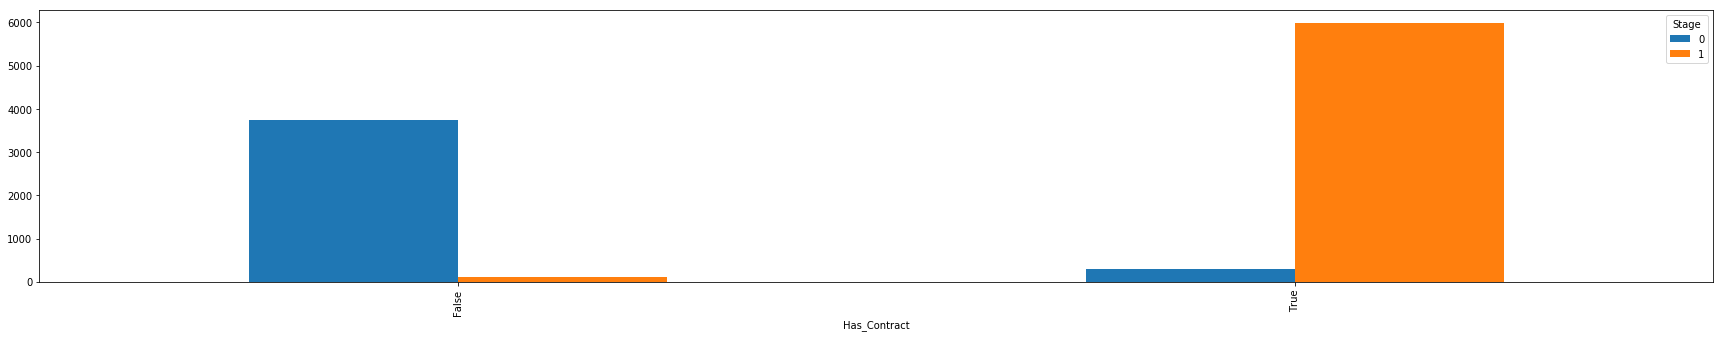

In [62]:
pd.crosstab(df[~df.Offer_Duration.isna()].Has_Contract, df[~df.Offer_Duration.isna()].Stage).plot(kind = "bar")

In [8]:
df.Has_Contract.value_counts()

True     7600
False    5642
Name: Has_Contract, dtype: int64

In [10]:
validation.Has_Contract.value_counts()

True     1244
False    1076
Name: Has_Contract, dtype: int64

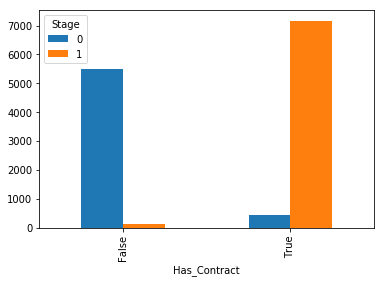

In [11]:
pd.crosstab(df.Has_Contract, df.Stage).plot(kind = "bar")

In [59]:
len(df[(df.Has_Contract == True) & (df.Stage == 0)])

579

In [60]:
len(df[(df.Has_Contract == False) & (df.Stage == 1)])

138

In [61]:
len(df)

16883